In [1]:
#!/usr/bin/env python3
#in this script we will extract CD4 and CD8 T cells from the panfetal cell atlas

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [16]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/panfetal_whole/panfetal_whole.h5ad")

In [17]:
adata.obs["celltype_annotation"]

FCAImmP7579224-ATTACTCTCGATGAGG          CYCLING_DC
FCAImmP7579224-CAGCCGAGTACATCCA           EARLY_ERY
FCAImmP7579224-TGCTACCTCATGTAGC             PRE_DC2
FCAImmP7579224-ACGGCCACAAGCTGAG    MONOCYTE_II_CCR2
FCAImmP7579224-CTAATGGCACTGTGTA         LARGE_PRE_B
                                         ...       
FCAImmP7803042-AGTGGGAGTCGACTGC     FIBROBLAST_XIII
FCAImmP7803042-CCATTCGTCAACACAC        FIBROBLAST_V
FCAImmP7803042-CGTAGCGAGTGACATA        FIBROBLAST_I
FCAImmP7803042-TGGCCAGCAATGAAAC       FIBROBLAST_IV
FCAImmP7803042-ATTGGACAGGAGTACC        KERATINOCYTE
Name: celltype_annotation, Length: 911873, dtype: category
Categories (138, object): ['ABT(ENTRY)', 'AS_DC', 'B1', 'CD4+T', ..., 'VSMC_PERICYTE_II', 'VSMC_PERICYTE_III', 'YS_ERY', 'YS_STROMA']

In [18]:
adata.obs["anno_lvl_2_final_clean"]

FCAImmP7579224-ATTACTCTCGATGAGG          CYCLING_DC
FCAImmP7579224-CAGCCGAGTACATCCA           EARLY_ERY
FCAImmP7579224-TGCTACCTCATGTAGC             PRE_DC2
FCAImmP7579224-ACGGCCACAAGCTGAG    MONOCYTE_II_CCR2
FCAImmP7579224-CTAATGGCACTGTGTA         LARGE_PRE_B
                                         ...       
FCAImmP7803042-AGTGGGAGTCGACTGC     FIBROBLAST_XIII
FCAImmP7803042-CCATTCGTCAACACAC        FIBROBLAST_V
FCAImmP7803042-CGTAGCGAGTGACATA        FIBROBLAST_I
FCAImmP7803042-TGGCCAGCAATGAAAC       FIBROBLAST_IV
FCAImmP7803042-ATTGGACAGGAGTACC        KERATINOCYTE
Name: anno_lvl_2_final_clean, Length: 911873, dtype: category
Categories (138, object): ['ABT(ENTRY)', 'AS_DC', 'B1', 'CD4+T', ..., 'VSMC_PERICYTE_II', 'VSMC_PERICYTE_III', 'YS_ERY', 'YS_STROMA']

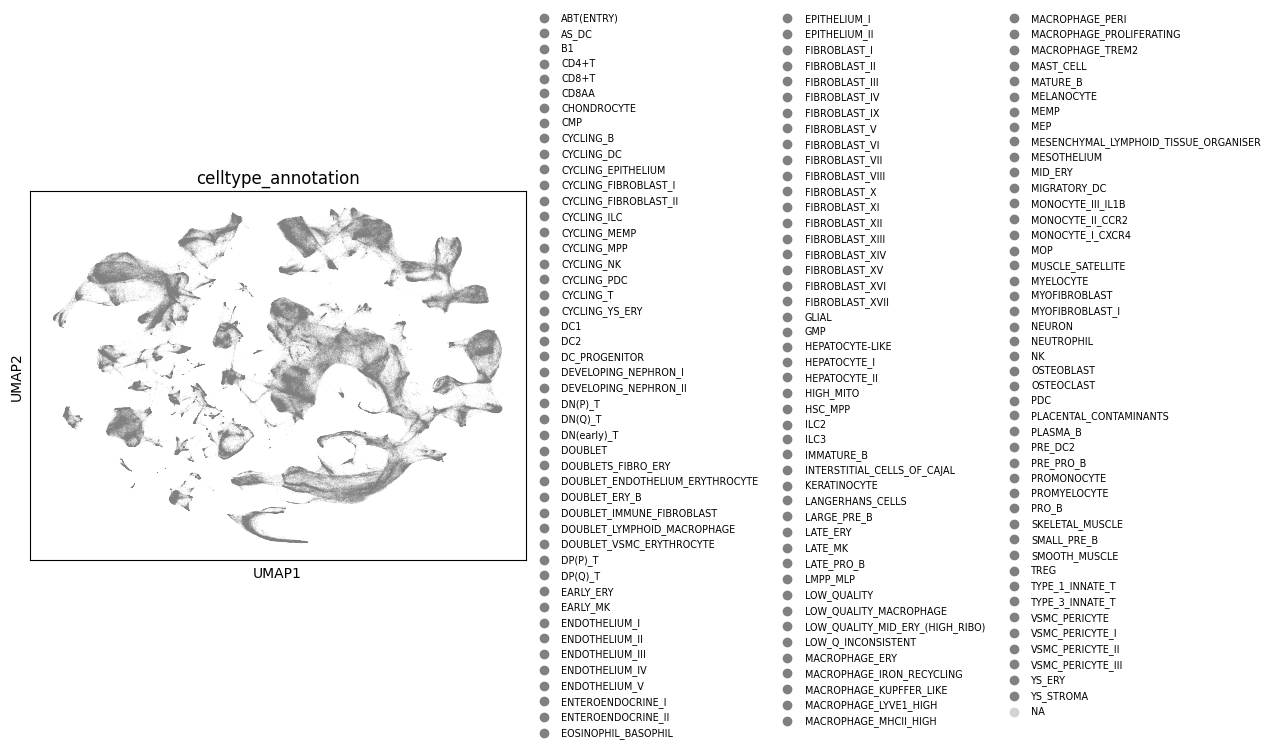

In [19]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='right margin', legend_fontsize='x-small')

In [20]:
#first we will subset out the SP T cells
cell_types_to_keep = ["CD8+T", "CD4+T"]
adata = adata[adata.obs['celltype_annotation'].isin(cell_types_to_keep)].copy() 

In [21]:
print(adata)

AnnData object with n_obs × n_vars = 23018 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap', 'celltype_annotation_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [22]:
#examine the donor metadata
adata.obs["donor"]

FCAImmP7579224-AATCGGTCATGCCTTC    F45
FCAImmP7579224-CGAGCACGTTGTCTTT    F45
FCAImmP7579224-GGCTCGAGTAGGAGTC    F45
FCAImmP7579224-GGTGTTAAGATCCCAT    F45
FCAImmP7579224-TTCTACAGTAGCACGA    F45
                                  ... 
FCAImmP7277565-GGGCACTGTCAGCTAT    F30
FCAImmP7277565-TTGCGTCAGAGGGCTT    F30
FCAImmP7277565-TGGCTGGCAAGGCTCC    F30
FCAImmP7277565-CTGATAGGTGCGAAAC    F30
FCAImmP7277565-CAAGGCCGTCGATTGT    F30
Name: donor, Length: 23018, dtype: category
Categories (22, object): ['F21', 'F23', 'F29', 'F30', ..., 'F71', 'F72', 'F73', 'F78']

In [23]:
#performing quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [24]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

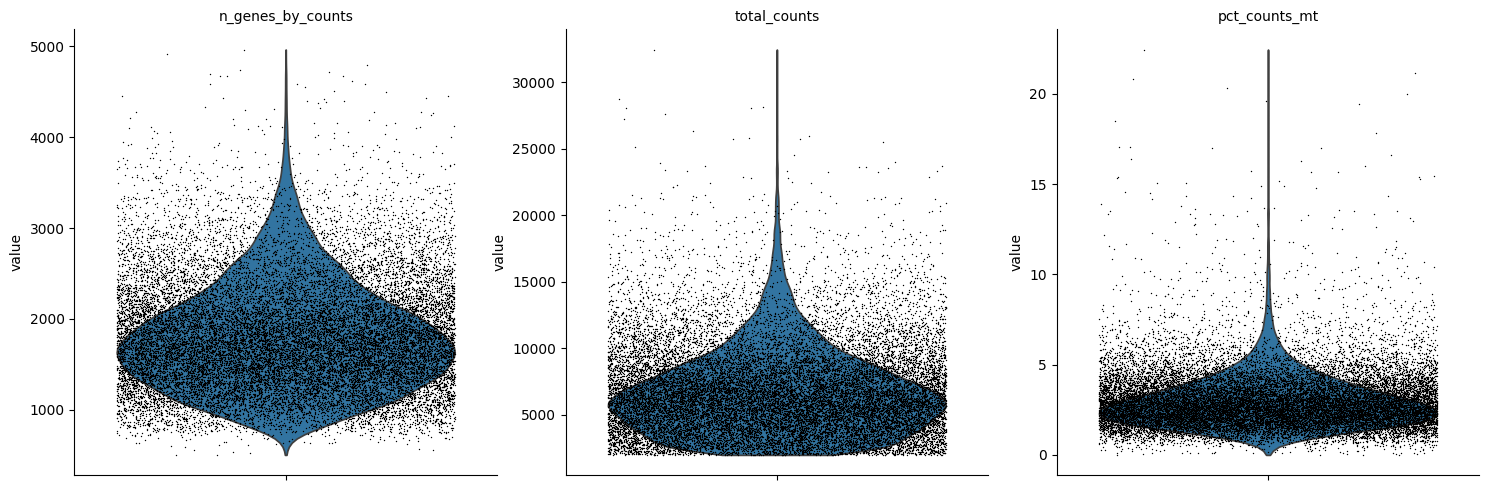

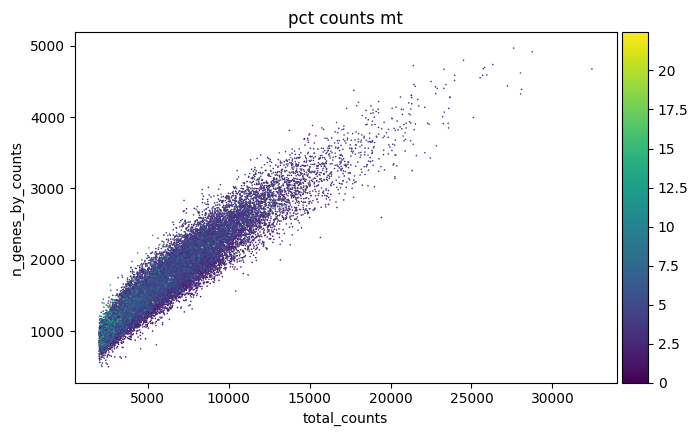

In [25]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [28]:
#it seems that QC has already been applied to the above cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

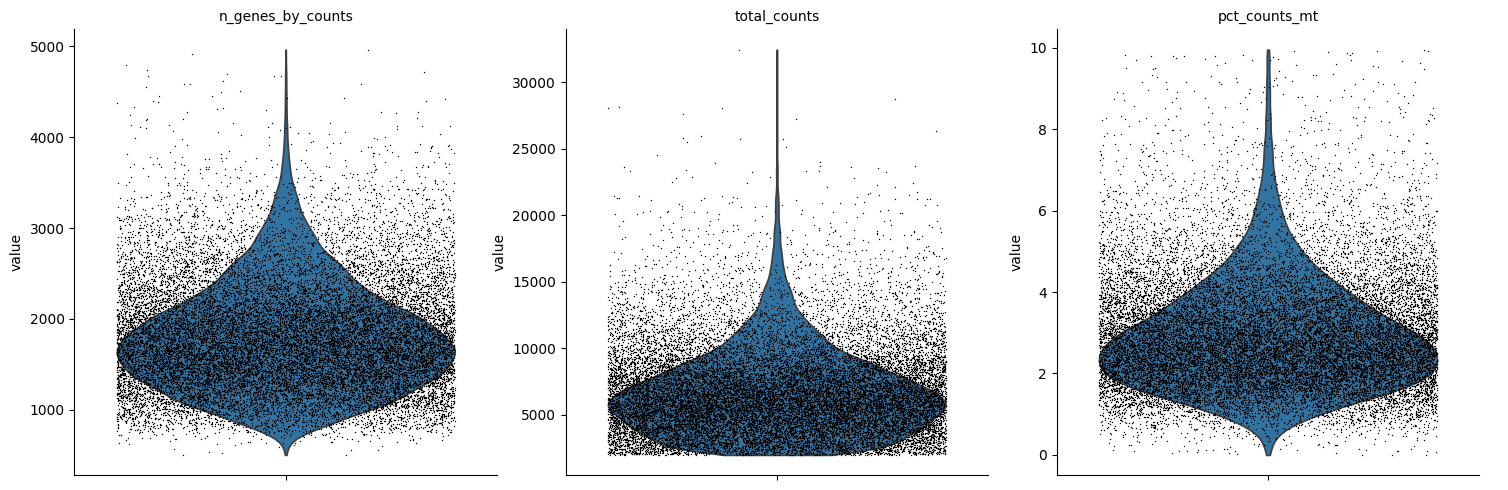

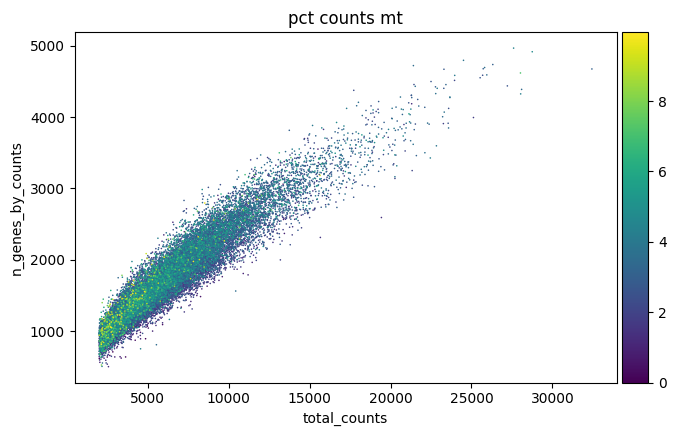

In [29]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [30]:
adata.obs['predicted_doublets'].value_counts()

predicted_doublets
False    22869
True         3
Name: count, dtype: int64

In [31]:
adata = adata[adata.obs['predicted_doublets'] == 'False'].copy()

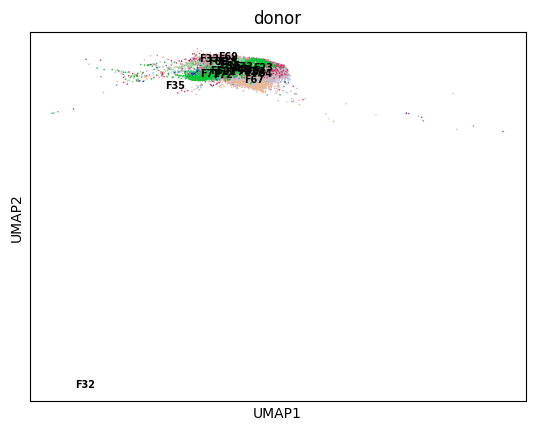

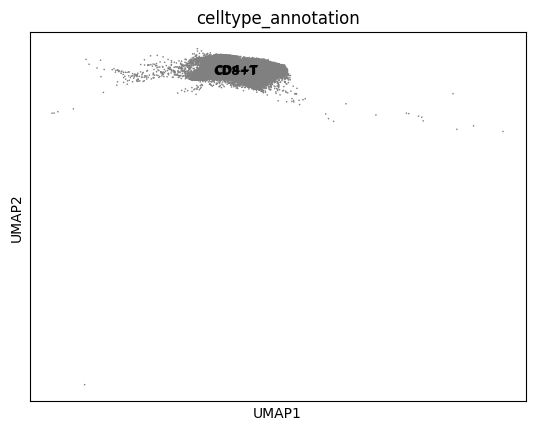

In [34]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='small')

In [33]:
#examine the donor metadata
adata.obs["donor"]

FCAImmP7579224-AATCGGTCATGCCTTC    F45
FCAImmP7579224-CGAGCACGTTGTCTTT    F45
FCAImmP7579224-GGCTCGAGTAGGAGTC    F45
FCAImmP7579224-GGTGTTAAGATCCCAT    F45
FCAImmP7579224-TTCTACAGTAGCACGA    F45
                                  ... 
FCAImmP7277565-GGGCACTGTCAGCTAT    F30
FCAImmP7277565-TTGCGTCAGAGGGCTT    F30
FCAImmP7277565-TGGCTGGCAAGGCTCC    F30
FCAImmP7277565-CTGATAGGTGCGAAAC    F30
FCAImmP7277565-CAAGGCCGTCGATTGT    F30
Name: donor, Length: 22869, dtype: category
Categories (22, object): ['F21', 'F23', 'F29', 'F30', ..., 'F71', 'F72', 'F73', 'F78']

In [35]:
adata.obs['donor'].value_counts()

donor
F50    3129
F29    2825
F51    2709
F67    2379
F30    2061
F38    1781
F21    1746
F41    1526
F72    1374
F78    1210
F45     969
F71     265
F66     235
F73     220
F23     206
F64     156
F33      38
F34      27
F35       8
F37       2
F69       2
F32       1
Name: count, dtype: int64

In [43]:
#selecting F38, F21, F41, F72, F78
donors_to_keep = ['F38','F21', 'F41', 'F72', 'F78']

# filter AnnData
adata_filtered = adata[adata.obs['donor'].isin(donors_to_keep)].copy()

In [44]:
print(adata_filtered)

AnnData object with n_obs × n_vars = 7637 × 20501
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'scvi', 'umap', 'celltype_annotation_colors', 'donor_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


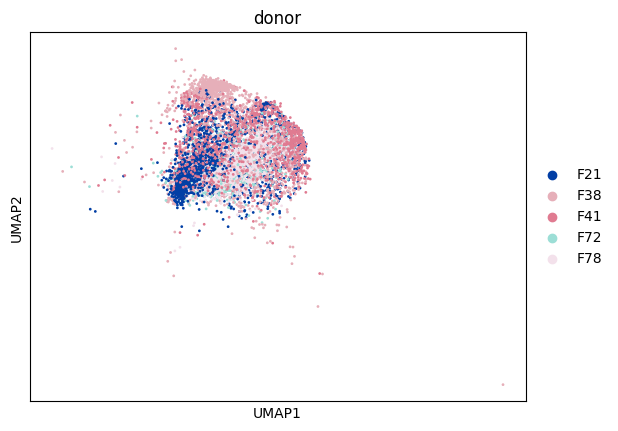

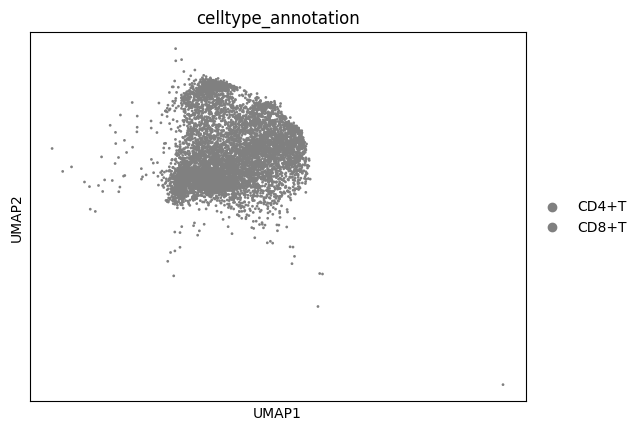

In [45]:
sc.pl.umap(adata_filtered, color = "donor")
sc.pl.umap(adata_filtered, color = "celltype_annotation")

In [49]:
adata_filtered.obs['celltype_annotation'].value_counts()

celltype_annotation
CD4+T    4918
CD8+T    2719
Name: count, dtype: int64

In [50]:
adata_filtered.obs['donor'].value_counts()

donor
F38    1781
F21    1746
F41    1526
F72    1374
F78    1210
Name: count, dtype: int64

In [52]:
#now we extract each cell type
adata_cd4 = adata_filtered[adata_filtered.obs['celltype_annotation'] == "CD4+T"].copy()
adata_cd8 = adata_filtered[adata_filtered.obs['celltype_annotation'] == "CD8+T"].copy()

In [53]:
#and downsample them to be 2500 cells each

#start with cd4 T cells
#set seed for reproducibility
np.random.seed(42)  # set the seed globally

# Choose 2500 random indices from the total number of cells
selected_indices = np.random.choice(adata_cd4.n_obs, size=2500, replace=False)

# Subset the AnnData object
adata_cd4 = adata_cd4[selected_indices].copy()

In [54]:
#then cd8
# Choose 2500 random indices from the total number of cells
selected_indices = np.random.choice(adata_cd4.n_obs, size=2500, replace=False)

# Subset the AnnData object
adata_cd8 = adata_cd8[selected_indices].copy()

In [55]:
adata_downsampled = ad.concat([adata_cd4, adata_cd8], axis=0) 

In [56]:
print(adata_downsampled)

AnnData object with n_obs × n_vars = 5000 × 20501
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    obsm: 'X_scvi', 'X_umap'


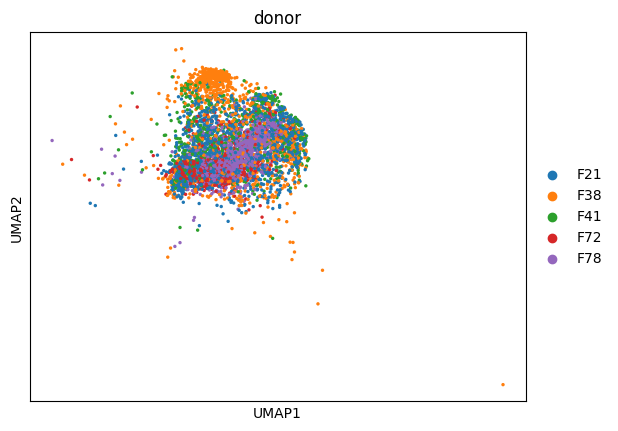

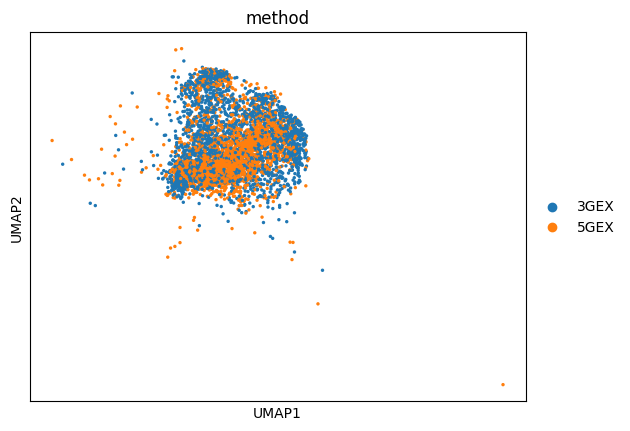

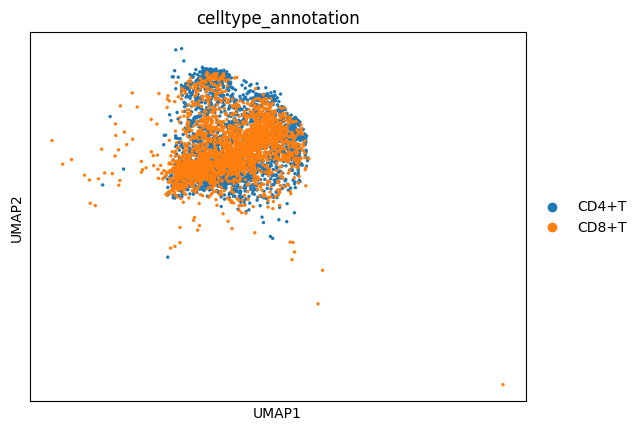

In [59]:
sc.pl.umap(adata_downsampled, color="donor")
sc.pl.umap(adata_downsampled, color="method")
sc.pl.umap(adata_downsampled, color="celltype_annotation")

In [61]:
adata_downsampled.obs['donor'].value_counts()

donor
F21    1288
F38    1092
F78     933
F72     865
F41     822
Name: count, dtype: int64

In [62]:
adata_downsampled.obs['celltype_annotation'].value_counts()

celltype_annotation
CD4+T    2500
CD8+T    2500
Name: count, dtype: int64

In [63]:
#exporting extracted data
#exporting count data

# Convert to DataFrame with cells as rows, genes as columns
count_df = pd.DataFrame(
    adata_downsampled.X.toarray() if hasattr(adata_downsampled.X, "toarray") else adata_downsampled.X,
    index=adata_downsampled.obs_names,
    columns=adata_downsampled.var_names
)

In [64]:
# Save the DataFrame to a .tsv file
count_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/reference_data/conv_T/countdata.tsv", sep='\t')

In [66]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata_downsampled.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/reference_data/conv_T/metadata.csv")